:# Introduction Lesson 6 & 7: Object detection
- Video >> https://www.youtube.com/watch?v=Z0ssNAbe81M
- wiki >> http://forums.fast.ai/t/part-2-lesson-8-wiki/13556
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-8-5ae195c49493

The main topic of these 2 lessons is object detection, which means getting a model to draw a box around every key object in an image, and label each one correctly. You may be surprised to discover that we can use transfer learning from an <b>ImageNet</b> classifier that was never even trained to do detection! There are two main tasks:
- find and localize the objects,
- and classify them

we’ll use a single model to do both these at the same time. Such multi-task learning generally works better than creating different models for each task—which many people find rather counter-intuitive.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/PPT1.png" width="80%">

# Lesson 6 : Detect and Classify the biggest object
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/PPT2.png" width="80%">

<b>In this lesson, we are going to apprehend gradually this detection and classification task. As explained by JH, instead of trying to solve the big problem, it is rather easier to decompose into sub tasks or start from something simple, then, step by step, increase the complexity until we reach our final objective</b>
So, we are going to follow these steps:
- Classify the biggest object
- Predict Bounding box of biggest object
- Put all together to predict and classify the biggest object

In [ ]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-uaqr188j
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras.git /tmp/pip-req-build-uaqr188j
  Resolved https://github.com/keras-team/keras.git to commit 24f104ecb31ccf367c4c0764515e4ba840d680e5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-51202pho
  Running command git clone --filter=blob:none --quiet https://github.com/valeoai/dl_utils.git /tmp/pip-req-build-51202pho
  Resolved https://github.com/valeoai/dl_utils.git to commit abd677290660c7c090155d5e593fe699edf98203
  Preparing metadata (setup.py) ... done


In [1]:
import keras
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

One you download and unzip your dataset, your folder will look like this:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!rm -Rf VOCdevkit


In [4]:
import os
if not os.path.isdir('./VOCdevkit/'):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    #! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    #! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007
     #! cp /content/drive/MyDrive/Colab\ Notebooks/Dl_Dr_sallab_youtube/ved_8/pascal_train2007.json  VOCdevkit/VOC2007/pascal_train2007.json



--2025-06-10 18:06:25--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  22.5MB/s    in 23s     

2025-06-10 18:06:49 (19.0 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [5]:
! cp /content/drive/MyDrive/Colab\ Notebooks/Dl_Dr_sallab_youtube/ved_8/pascal_train2007.json  VOCdevkit/VOC2007/pascal_train2007.json


In [6]:
!ls "/content/drive/MyDrive/Colab Notebooks/Dl_Dr_sallab_youtube/ved_8/"


 06_Single_Object_Detection.ipynb
'07_multi label classification.ipynb'
 08_multiple_object_detection.ipynb
 cGAN.ipynb
 pascal_train2007.json
'Training YOLOv3 object detection on a custom dataset-Yolov3.ipynb'


In [7]:
from pathlib import Path

PATH = Path('VOCdevkit/VOC2007/')
for i in PATH.iterdir(): print(i)

JPEGS = PATH/'JPEGImages'

VOCdevkit/VOC2007/Annotations
VOCdevkit/VOC2007/SegmentationClass
VOCdevkit/VOC2007/pascal_train2007.json
VOCdevkit/VOC2007/ImageSets
VOCdevkit/VOC2007/JPEGImages
VOCdevkit/VOC2007/SegmentationObject


so, you have:
- <kbd>JPEGImages</kbd> folder containing all the images
- <kbd>Annotations</kbd> folder containing all the annotation, one XML annotation file per image file

The original version were in XML, which is a little hard to work with nowadays, so we use the more recent JSON version

In [8]:

import json

BD = json.load((PATH/'pascal_train2007.json').open()) # it loads a dictionary

print('the dictionary of keys: ',BD.keys())

the dictionary of keys:  dict_keys(['images', 'annotations', 'categories'])


In [9]:
# Then, we can acces to the image
BD['images'][:5]

[{'file_name': '000005.jpg', 'height': 375, 'width': 500, 'id': 1},
 {'file_name': '000007.jpg', 'height': 333, 'width': 500, 'id': 2},
 {'file_name': '000009.jpg', 'height': 375, 'width': 500, 'id': 3},
 {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 4},
 {'file_name': '000016.jpg', 'height': 500, 'width': 334, 'id': 5}]

In [10]:
# The annotations
BD['annotations'][:2]

[{'id': 1,
  'image_id': 1,
  'category_id': 9,
  'bbox': [262, 210, 61, 128],
  'area': 7808,
  'ignore': 0,
  'iscrowd': 0,
  'segmentation': [[262, 210, 323, 210, 323, 338, 262, 338]]},
 {'id': 2,
  'image_id': 1,
  'category_id': 9,
  'bbox': [164, 263, 88, 108],
  'area': 9504,
  'ignore': 0,
  'iscrowd': 0,
  'segmentation': [[164, 263, 252, 263, 252, 371, 164, 371]]}]

In [11]:
# and all category
BD['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

Finally, we want to create a dictionary to make cross reference between images and their annotation! Here, we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In VOC, the boxes are encoded as [x,y,h,w], where x,y is the top left coordinates. Moreover, the x,y direction is taken downwards, where x is pointing vertical down and y is point horizontal right.

We want to convert this system into [x1,y1,x2,y2], where each pair encodes the coordinates of top left and bottom right points. Moreover, x and y system is flipped (x1 = y and y1 = x), (x2=y+w, y2=x+h).

In [12]:
import collections

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# we convert categories into dictionary
data_category = dict((o['id'],o['name']) for o in BD['categories']) # all the categories
data_filename = dict((o['id'],o['file_name']) for o in BD['images']) # image id to image filename
data_ids = [o['id'] for o in BD['images']] # list of all the image IDs

annotations = collections.defaultdict(lambda:[])
for o in BD['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = hw_bb(bb)
        annotations[o['image_id']].append((bb,o['category_id']))

print('we have',len(BD['annotations']),'annotations')

we have 15662 annotations


## some convenient display functions

In [ ]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8)) # That's why the image with draw_im is zoomed in
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], data_category[c], sz=16)

def draw_idx(i):
    im_a = annotations[i]
    im = image.imread(JPEGS/data_filename[i])
    draw_im(im, im_a)

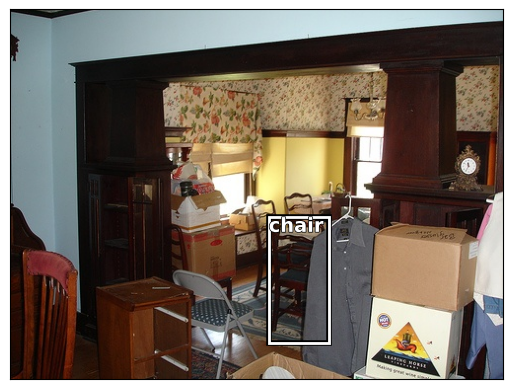

In [ ]:
im = image.imread(JPEGS/data_filename[data_ids[0]])

ax = show_img(im)
bbox = annotations[ data_ids[0]][0][0]
clas_id = annotations[data_ids[0]][0][1]
bbox = bb_hw(bbox)

draw_rect(ax, bbox)
draw_text(ax, bbox[:2], data_category[clas_id])

In [ ]:
data_ids[0]

1

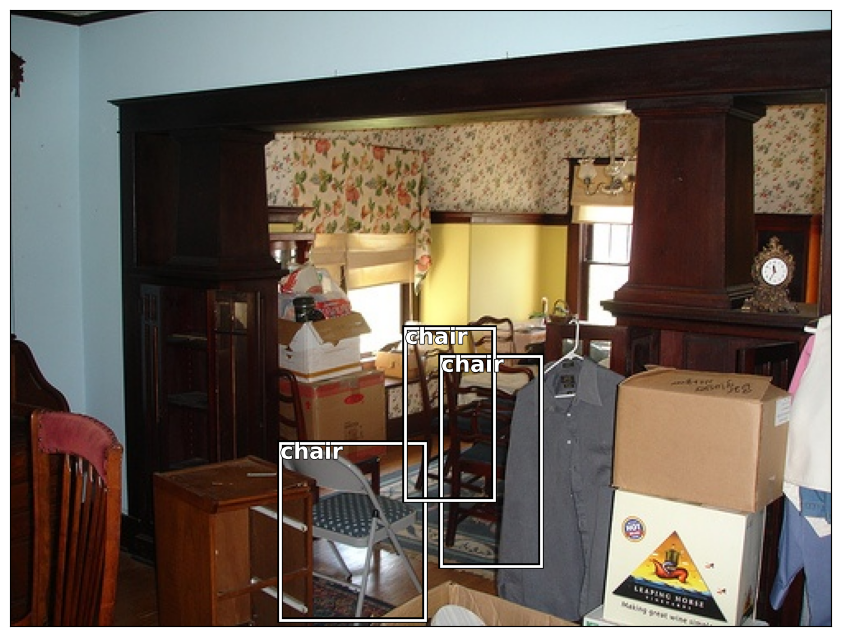

In [ ]:
draw_idx(1)

## Step 1: Largest item classifier

We are going to create a classifier to predict the class of the biggest object in the image.
For that purpose, we need to structure our learning data in a scalable manner as we will, step by step, increase the complexity of our task.

### Setup the data folder
___copy vs. point___

__Flow from directory means to copy__

So, there are plenty of way to do that, but in Fast.ai, they use a csv file to list all images/labels instead of creating a new directory and copying inside all the needed data. For sure, it sounds better than recreating a folder and copying all the need images and labels... not really convenient, neither scalable. And finally, they have this nice function to train directly from a CSV file.

__Flow from dataframe__
In August 2018, Keras came with a super usefull function called <kbd>flow_from_dataframe</kbd>!!! Great, no more code to do, it is a method from <kbd>ImageDataGenerator</kbd>, and uses same properties, that is to say we can even do Data AUgmentation!

So, before doing anything with the data, that is to say jump to the conclusion, we have first to figure out how we will provide the data to our network. As we said before, Keras can use Dataframe to represent the data.

What do we put them in our dataframe? We want for each image to have a classification tag. Sounds pretty easy, right?

So,it's supposed to look like this

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/dataframe.png" width="30%">

Let's do it now!

### Pandas

We said bebore that we were going to use CSV files. Actually we will use dataframe to list all of our data.

<kbd>Pandas</kbd> lib is the standard lib to create CSV file.

In [ ]:
x = np.array([10,10,20,20])


In [ ]:
x[-2:]

array([20, 20])

In [ ]:
x[:2]

array([10, 10])

In [ ]:
x[-2:]-x[:2]

array([10, 10])

In [ ]:
print(np.prod(x[-2:]-x[:2]))

100


In [15]:

import pandas as pd

def get_largest_annotation(b):
    if not b: raise Exception()
    # Sort by area = LxW = (x1-x2)*(y1-y2)
    #x[0] as each annotation is a tuple (bb, cls)
    b = sorted(b, key=lambda x: np.prod(  x[0][-2:]-x[0][:2]  ) , reverse=True)
    return b[0]


filename=[]
C=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    # data_category is a tuple (id, name), we want to annotate by name so we index at [1]
    C.append(data_category[ get_largest_annotation(annotation)[1] ])

df = pd.DataFrame({'filename': filename, 'class': C}, columns=['filename','class'])

df[:5]

filename    class
0  000005.jpg    chair
1  000007.jpg      car
2  000009.jpg    horse
3  000012.jpg      car
4  000016.jpg  bicycle

### Split our data into training and validation set
We can also use sklearn.train_test_split

In [16]:


# create a training and validation set

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))

    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))

    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

# Data generators, why?

## RAM size
Imagine a dataset of 10K images, each of 1M size. If you load this in memory, you have at least 10GB of RAM.
To avoid this, you can load it batch by batch. This is the first importance of data generators.

## Data augmentation
The easiest way to do Data Augmentation is to create an <kbd>ImageDataGenerator</kbd> and specify the transformation properties. Be carefull, remember that the data needs to be preprocessed to be compatible with the model used (VGG16).

__Preprocess input__
https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras

Keras works with batches of images. So, the first dimension is used for the number of samples (or images) you have.

When you load a single image, you get the shape of one image, which is (size1,size2,channels).

In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels)

The preprocess_input function is meant to adequate your image to the format the model requires.

Some models use images with values ranging from 0 to 1. Others from -1 to +1. Others use the "caffe" style, that is not normalized, but is centered.

From the source code, Resnet is using the caffe style.

You don't need to worry about the internal details of preprocess_input. But ideally, you should load images with the keras functions for that (so you guarantee that the images you load are compatible with preprocess_input).

In [20]:
# our batch size
bs=32
# define the size of our input data
sz=224

# preprocess_input is for VGG16 in our case
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_batches = train_datagen.flow_from_dataframe(df_train, # The df
                                                  JPEGS, # Place on desk
                                                  x_col='filename', # The column to get x
                                                  y_col='class', # The column to get y
                                                  has_ext=True,
                                                  target_size=(sz, sz),
                                                  color_mode='rgb',
                                                  classes=None,
                                                  class_mode='categorical',
                                                  batch_size=bs,
                                                  shuffle=True)



valid_batches = valid_datagen.flow_from_dataframe(df_valid,
                                                  JPEGS,
                                                  x_col='filename',
                                                  y_col='class',
                                                  has_ext=True,
                                                  target_size=(sz, sz),
                                                  color_mode='rgb',
                                                  classes=list(train_batches.class_indices),
                                                  class_mode='categorical',         # this line make one hot in codeing
                                                  batch_size=bs,
                                                  shuffle=False)

NbClasses = len(train_batches.class_indices)

Found 3507 validated image filenames belonging to 20 classes.
Found 1504 validated image filenames belonging to 20 classes.


### 1.2: Create our model

Now, we need a model. Similar as before, we are going to use a model from <kbd>keras.application</kbd>. This time, it will be a VGG16 model.

In [ ]:
net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False

# we add our classification layer
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NbClasses, activation='softmax', name='softmax')(x)
model = Model(inputs=net.input, outputs=output_layer)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 20)             │       501,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,216,468 (58.05 MB)

 Trainable params: 501,780 (1.91 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 1.3: Define an optimizer and a Loss function

In [ ]:
epochs = 20

opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

### 1.4: It is time to train now

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 85s 639ms/step - accuracy: 0.2570 - loss: 22.4316 - val_accuracy: 0.5532 - val_loss: 9.0487
Epoch 2/20
  1/109 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.5000 - loss: 13.4273

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5000 - loss: 13.4273 - val_accuracy: 0.5525 - val_loss: 9.0263
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 59s 545ms/step - accuracy: 0.4745 - loss: 12.7000 - val_accuracy: 0.6423 - val_loss: 7.4031
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.3125 - loss: 18.0192 - val_accuracy: 0.6430 - val_loss: 7.3944
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 550ms/step - accuracy: 0.5433 - loss: 10.4071 - val_accuracy: 0.6755 - val_loss: 6.6945
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.4737 - loss: 17.1078 - val_accuracy: 0.6755 - val_loss: 6.6777
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 59s 534ms/step - accuracy: 0.5988 - loss: 8.8253 - val_accuracy: 0.6902 - val_loss: 6.3224
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.6875 - loss: 5.9110 - val_accuracy: 0.6935 - val_loss: 6.3217
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 529ms/step - accuracy: 0.6483 - loss: 7.6209 - val_a

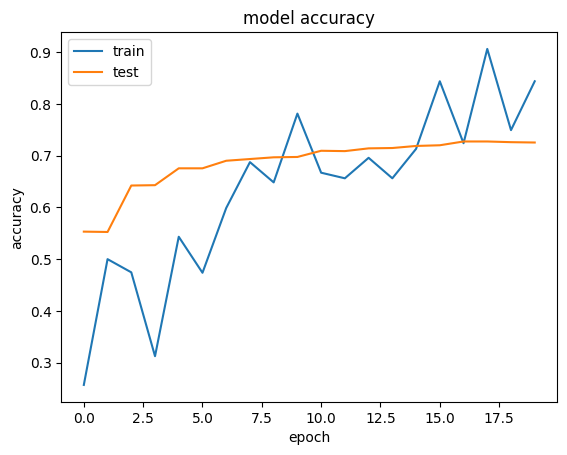

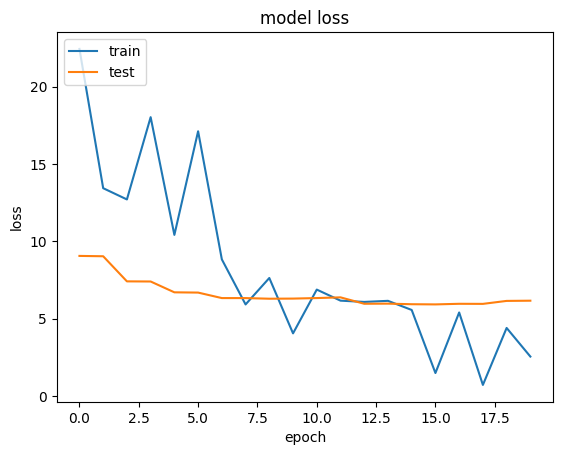

In [ ]:
history = model.fit(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.5: unfreeze couple of layers
Notice that the acc starts from what reached before, this is becuase we just re-compile the model. This leaves the weights untouched. If we want to re-init the weights we have to call K.clear_session(), but we don't want that in our case.

In [ ]:
#unfreeze initial layers
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 20)             │       501,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,220,030 (61.87 MB)

 Trainable params: 7,581,204 (28.92 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 1,003,562 (3.83 MB)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 70s 586ms/step - accuracy: 0.7315 - loss: 3.3645 - val_accuracy: 0.7121 - val_loss: 3.5223
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7188 - loss: 2.3279 - val_accuracy: 0.7121 - val_loss: 3.5157
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 65s 570ms/step - accuracy: 0.7079 - loss: 2.4854 - val_accuracy: 0.7214 - val_loss: 2.9172
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9062 - loss: 1.2582 - val_accuracy: 0.7221 - val_loss: 2.9121
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 71s 553ms/step - accuracy: 0.7275 - loss: 1.9268 - val_accuracy: 0.7154 - val_loss: 2.4567
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.6875 - loss: 0.8884 - val_accuracy: 0.7148 - val_loss: 2.4537
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 567ms/step - accuracy: 0.7068 - loss: 1.7777 - val_accuracy: 0.7074 - val_loss: 2.2476
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.7188 - loss: 1.3830 -

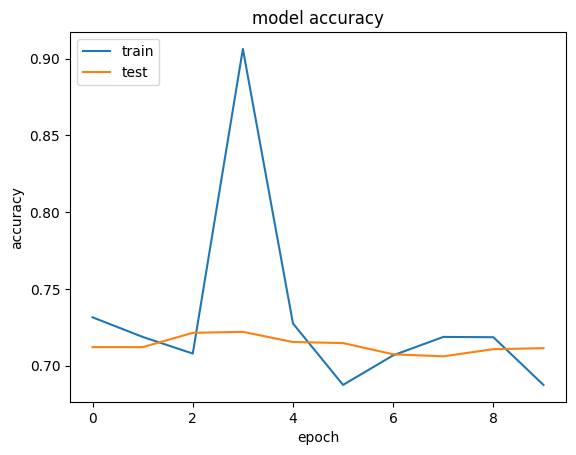

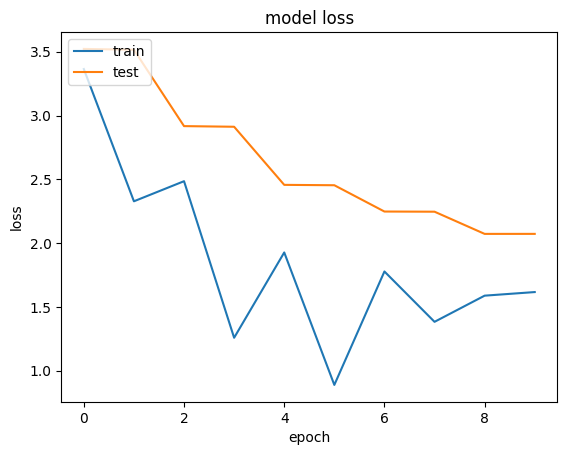

In [ ]:
epochs = 10

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.6: Check the result

`unprocess` function is just to inverse what `preprocess_fct` or `preprocess_input` (of VGG for for example) dir. Like normalization (multiply by std and add back the mean), or clipping (*255 again)

In [ ]:
from dlutils import unpreprocess

class_name = list(valid_batches.class_indices)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y =  next(valid_batches)
    image = x[0]
    proba = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)
    class_id = np.argmax(proba)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), class_name[class_id])

plt.tight_layout()

NameError: name 'valid_batches' is not defined

__Is that good?__

It's doing a pretty good job of classifying the largest object, 74% of accuracy!

Notice that; this is different from cats vs. dogs or cifar-10, since the images contain many objects this time, and we focus on the largest for now.

## Step 2: Bbox regression

### 2.1: The Data

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs.

In [ ]:
# we create this time our data frame with the box coordiantes

filename=[]
bbox=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    bbox.append(get_largest_annotation(annotation)[0])

df = pd.DataFrame({'filename': filename, 'bbox': bbox}, columns=['filename','bbox'])

df[:5]

filename                  bbox
0  000005.jpg  [263, 164, 370, 251]
1  000007.jpg   [49, 140, 328, 498]
2  000009.jpg   [171, 68, 328, 268]
3  000012.jpg   [96, 155, 268, 349]
4  000016.jpg    [71, 91, 471, 303]

In [ ]:
# create a training and validation set
df_train, df_valid = Split_Train_Valid(df,0.7)

# We cannot use data augmentation anymore!

Unfortunately, we can t really use as before the <kbd>flow_from_dataframe</kbd> function. There are several reasons, but the most important one is that we need to resize the image to fit to our input tensor and as a consequence, bounding boxes should be resized too!

# Solution 1: No data generators, no augmentation, just load everything in RAM!


We could also load all the data into memory because it s only 224*224 images, so the memory footprint would be quite reasonable. Then, we could use directly the <kbd>fit</kbd> function instead of <kbd>fit_generator</kbd>


# Solution 2: Make our own data generator!
We could think to create our own preprocessing function and pass it to the Generator but it would have access to the image only, not its label!

So, it is a blessing in disguise that we have to create our own Generator. We will learn something new today!

_For that you must implement __len__ and __get_item__


In [23]:
class DataFrame_Generator(keras.utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self, df, folder,preprocess_fct,batch_size=32, dim=(32,32), shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder

        # Load the dataframe
        # the database is not so big, especially when resized in 224*224.
        # so we have either the option to load images online for each batch or
        # we can load all image at once
        self.df = df
        self.n = len(df)
        self.nb_iteration = int(np.floor(self.n  / self.batch_size))

        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.zeros((self.batch_size,4))

        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder/self.df['filename'][ID])
            bb = self.df['bbox'][ID]

            # Resize according to the required size
            width, height = img.size
            RatioX = width/self.dim[0]
            RatioY = height/self.dim[1]

            img = np.asarray(img.resize(self.dim))

            # Resize the bbox accordingly
            bb = [bb[0]/RatioY,bb[1]/RatioX,bb[2]/RatioY,bb[3]/RatioX]

            # Same as done for VGG16
            X[i,] = self.preprocess_fct(np.asarray(img))

            Y[i] = bb
        return X, Y

In [ ]:
train_gen = DataFrame_Generator(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = DataFrame_Generator(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

Let's have a look to an example

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

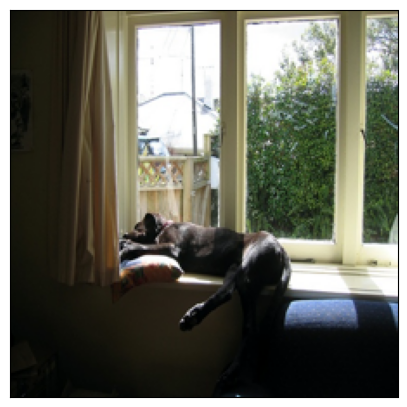

In [ ]:
x,y = next(iter(train_gen))# This is just a python iterator, supporting next--> calling __get_item__

ax = show_img(unpreprocess(x[0],'None','None'), figsize=(5,10))
draw_rect(ax, bb_hw(y[0]))

### 2.2: The model

Here, we want to predict the position of the bounding box.
Actually, we expect our model to predict 4 values: this is a regression problem.

As the difference with Classification, we do not expect a probability but real position values! Our network will be the same as before (especially because we want to share latter the feature encoder part) but instead of adding a classifcation layer with a SoftMax or Sigmoid function (to provide a probability) we only need to add a linear layer

In [ ]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False

x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='linear', name='linear')(x)
model = Model(inputs=net.input, outputs=output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear (Dense)                  │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 2.3: The optimizer

Our optimizer will optimize the task our model is designed for. Compared to before, we used a Cross-entropy as our Loss function to predict Category. Now, as we want to predict continuous values, we are going to use L1 (mean_absolute_error) or L2 Loss (mean_squared_error)

In [ ]:
optimizer=Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])

### 2.4: It's time to train

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.5129 - loss: 54.0527 - val_accuracy: 0.6350 - val_loss: 39.5718
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 377ms/step - accuracy: 0.6290 - loss: 37.2099 - val_accuracy: 0.6523 - val_loss: 35.3926
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 380ms/step - accuracy: 0.6574 - loss: 33.5000 - val_accuracy: 0.6922 - val_loss: 33.2869
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 474ms/step - accuracy: 0.6786 - loss: 31.2087 - val_accuracy: 0.6961 - val_loss: 32.1924
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 80s 458ms/step - accuracy: 0.6898 - loss: 29.5774 - val_accuracy: 0.7028 - val_loss: 31.3963
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 383ms/step - accuracy: 0.7010 - loss: 28.3339 - val_accuracy: 0.7134 - val_loss: 30.7463
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - accuracy: 0.7113 - loss: 26.9563 - val_accuracy: 0.7108 - val_loss: 30.4016
Epoch 8/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 387ms/step - accuracy: 0.

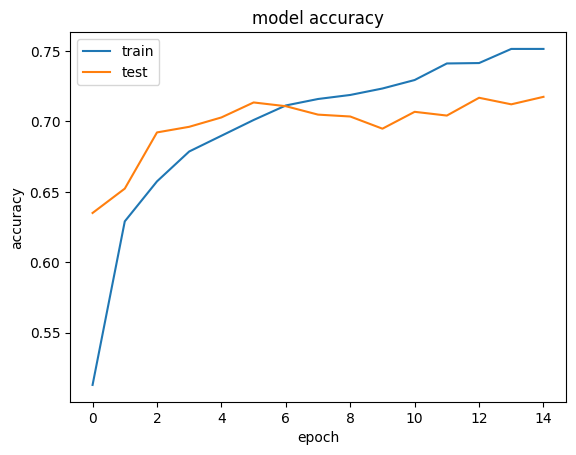

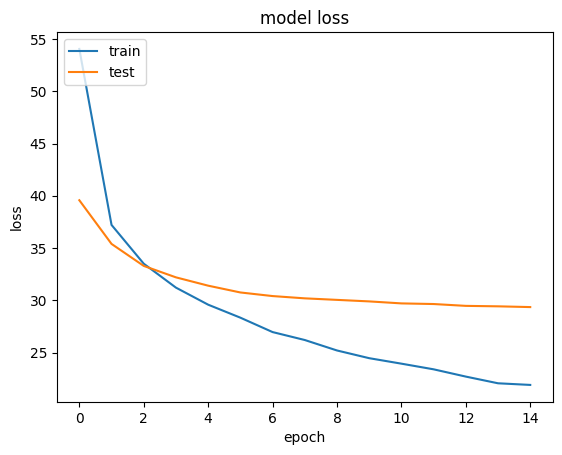

In [ ]:
epochs = 15

history = model.fit(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2.5: unfreeze couple of layers

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 7,179,780 (27.39 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 401ms/step - accuracy: 0.5490 - loss: 48.9217 - val_accuracy: 0.5924 - val_loss: 34.7582
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 390ms/step - accuracy: 0.5909 - loss: 38.4405 - val_accuracy: 0.5864 - val_loss: 41.8228
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 83s 396ms/step - accuracy: 0.5972 - loss: 37.6855 - val_accuracy: 0.5977 - val_loss: 33.4141
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - accuracy: 0.5992 - loss: 35.6463 - val_accuracy: 0.6097 - val_loss: 30.9920
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 43s 396ms/step - accuracy: 0.6187 - loss: 34.2433 - val_accuracy: 0.6642 - val_loss: 30.8357
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 476ms/step - accuracy: 0.6342 - loss: 32.3819 - val_accuracy: 0.6729 - val_loss: 30.6911
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 44s 399ms/step - accuracy: 0.6568 - loss: 31.0129 - val_accuracy: 0.6975 - val_loss: 32.1696
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 396ms/step - accuracy: 0.

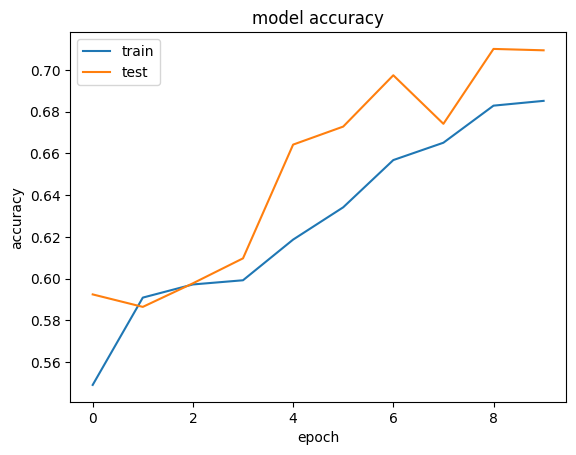

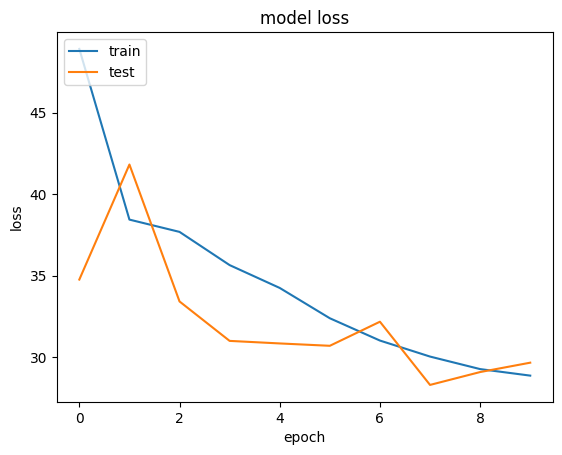

In [ ]:
net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))


FREEZE_LAYERS = 14
# Freeze first layers
for layer in net.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# Rebuild the model with updated trainable layers
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='linear')(x)
model = Model(inputs=net.input, outputs=output_layer)

# Compile again after changing trainable flags
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

model.summary()

# Train again
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.nb_iteration,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2.6: Check the result

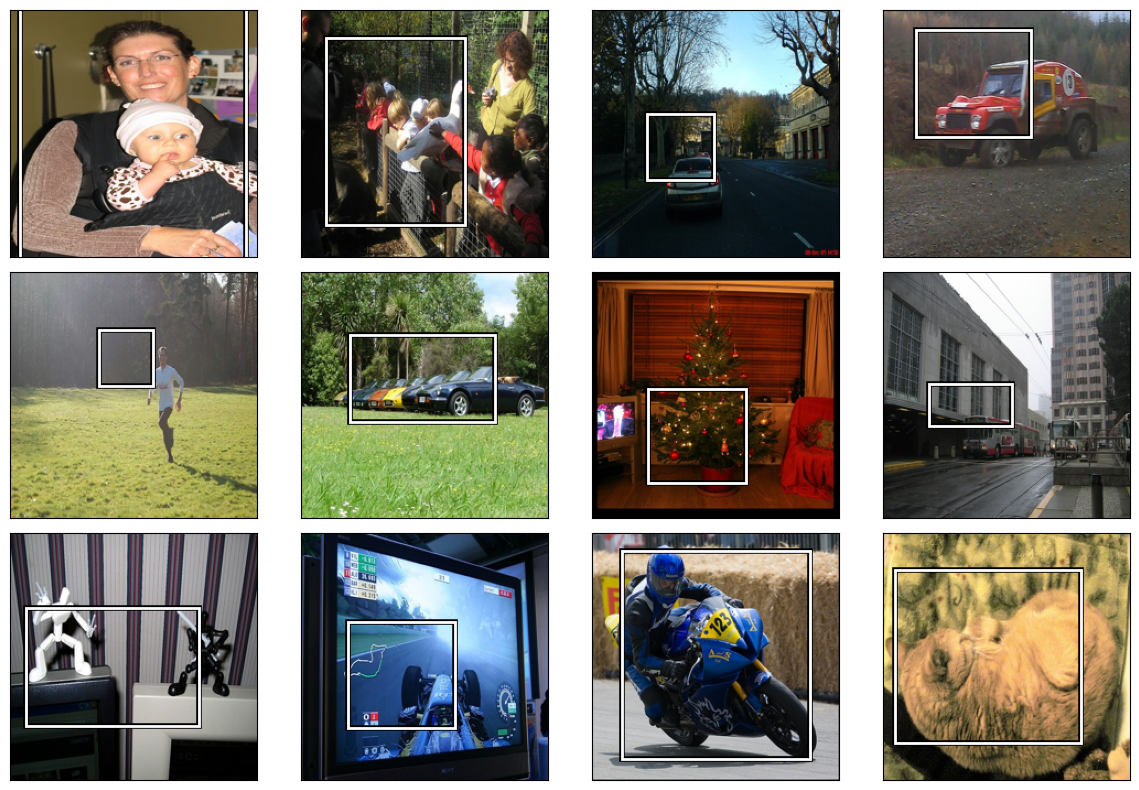

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = next(iter(valid_gen))
    image = x[i]
    bb = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)

    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb[0]))

plt.tight_layout()

## Step 3: Single object detection

We have now to combine the two individual tasks of classification and detection we have developped bedore. We know that independently, it works. Therefore, if we modify accordingly our data, our model, our Loss function... it should work too!

let's go...

# repaid some functtion

In [44]:
import keras
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image
import json


In [45]:

BD = json.load((PATH/'pascal_train2007.json').open()) # it loads a dictionary

print('the dictionary of keys: ',BD.keys())

the dictionary of keys:  dict_keys(['images', 'annotations', 'categories'])


In [46]:

import collections

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# we convert categories into dictionary
data_category = dict((o['id'],o['name']) for o in BD['categories']) # all the categories
data_filename = dict((o['id'],o['file_name']) for o in BD['images']) # image id to image filename
data_ids = [o['id'] for o in BD['images']] # list of all the image IDs

annotations = collections.defaultdict(lambda:[])
for o in BD['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = hw_bb(bb)
        annotations[o['image_id']].append((bb,o['category_id']))

print('we have',len(BD['annotations']),'annotations')



we have 15662 annotations


In [47]:
import pandas as pd

def get_largest_annotation(b):
    if not b: raise Exception()
    # Sort by area = LxW = (x1-x2)*(y1-y2)
    #x[0] as each annotation is a tuple (bb, cls)
    b = sorted(b, key=lambda x: np.prod(  x[0][-2:]-x[0][:2]  ) , reverse=True)
    return b[0]


filename=[]
C=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    # data_category is a tuple (id, name), we want to annotate by name so we index at [1]
    C.append(data_category[ get_largest_annotation(annotation)[1] ])

df = pd.DataFrame({'filename': filename, 'class': C}, columns=['filename','class'])

df[:5]


filename    class
0  000005.jpg    chair
1  000007.jpg      car
2  000009.jpg    horse
3  000012.jpg      car
4  000016.jpg  bicycle

In [48]:


# create a training and validation set

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))

    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))

    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

In [21]:
# we create this time our data frame with the box coordiantes

filename=[]
bbox=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    bbox.append(get_largest_annotation(annotation)[0])

df = pd.DataFrame({'filename': filename, 'bbox': bbox}, columns=['filename','bbox'])

df[:5]

filename                  bbox
0  000005.jpg  [263, 164, 370, 251]
1  000007.jpg   [49, 140, 328, 498]
2  000009.jpg   [171, 68, 328, 268]
3  000012.jpg   [96, 155, 268, 349]
4  000016.jpg    [71, 91, 471, 303]

In [37]:
import numpy as np
import keras
from PIL import Image
from tensorflow.keras.utils import to_categorical

class DataFrame_Generator(keras.utils.Sequence):
    'Generates data from a DataFrame for single-object detection'
    def __init__(self, df, folder, preprocess_fct, batch_size=32, dim=(224,224), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.folder = folder
        self.preprocess_fct = preprocess_fct
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.n = len(df)
        self.nb_iteration = int(np.floor(self.n / self.batch_size))

        # Get unique classes and class mapping
        self.classes = sorted(df['cat'].unique())
        self.class_map = {cat: idx for idx, cat in enumerate(self.classes)}
        self.NbClasses = len(self.classes)

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return self.nb_iteration

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index_array):
        X = np.empty((self.batch_size, *self.dim, 3))
        Y_bbox = np.zeros((self.batch_size, 4))
        Y_class = np.zeros((self.batch_size, self.NbClasses))

        for i, idx in enumerate(index_array):
            row = self.df.iloc[idx]

            img_path = self.folder / row['filename']
            img = Image.open(img_path).convert("RGB")

            # Resize and get scaling factors
            orig_width, orig_height = img.size
            img_resized = img.resize(self.dim)
            ratio_x = self.dim[0] / orig_width
            ratio_y = self.dim[1] / orig_height

            # Process image
            X[i] = self.preprocess_fct(np.array(img_resized))

            # Scale bbox
            x_min, y_min, x_max, y_max = row['bbox']
            Y_bbox[i] = [x_min * ratio_x, y_min * ratio_y, x_max * ratio_x, y_max * ratio_y]

            # One-hot encode class
            class_id = self.class_map[row['cat']]
            Y_class[i] = to_categorical(class_id, num_classes=self.NbClasses)

        return X, (Y_bbox, Y_class)



### 3.1: The Data

The data is still the image plus a tuple containing the bounding box coordinates and the category

In [49]:
df = pd.DataFrame({'filename': filename, 'cat':C, 'bbox': bbox}, columns=['filename','cat','bbox'])
df_train, df_valid = Split_Train_Valid(df,0.7)

In [50]:
train_gen = DataFrame_Generator(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = DataFrame_Generator(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

We put an updated version of the DataFrame Generator in the Utils lib

In [ ]:
#this is not work  ,and it equvelent to custom Data generator

# our batch size
bs=32
# define the size of our input data
sz=224
from dlutils import GeneratorSingleObject

#train_gen = GeneratorSingleObject(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
#valid_gen = GeneratorSingleObject(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

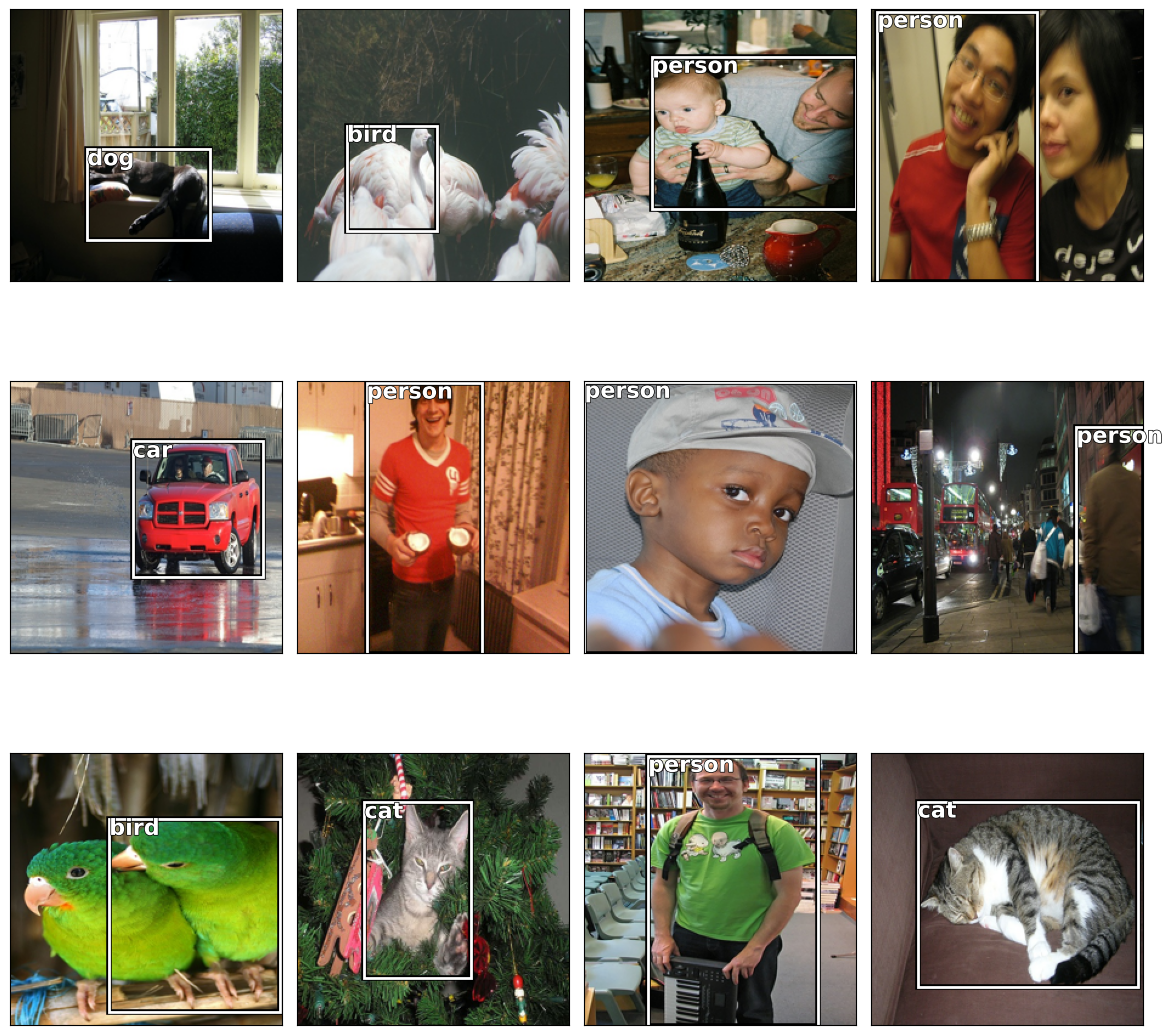

In [ ]:
from dlutils import unpreprocess

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(train_gen))
    bb = y_batch[0][i]
    cat = y_batch[1][i]
    image = x_batch[i]

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

### 3.2: The model

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

Notice, the importance of Keras functional API. With sequential API, this multi-output model is not possible.

In [51]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False

y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)




# branch for the regression --> BBox
output_layer_bbox = Dense(4, activation='linear', name='layer_bbox')(y)

# Branch for the classification --> Category
output_layer_class = Dense(train_gen.NbClasses, activation='softmax', name='layer_class')(y)

model = Model(inputs=net.input, outputs=[output_layer_bbox,output_layer_class])

### 3.3: The optimizer

Here, we need to combine the two Loss function for each branch.
Because each Loss will have different range, it is then better to set a weight on each of them.
We can check from the previous individual training to put the weight accordingly so that each branch has the same influence

In [52]:
optimizer=Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'],metrics=['mae', 'accuracy'],loss_weights=[1., 5.])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,316,824 (58.43 MB)

 Trainable params: 602,136 (2.30 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 3.4: Time to train

In [ ]:
epochs = 20

history=model.fit(train_gen,
          validation_data=valid_gen,
          epochs=20,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen))


print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3130s 58s/step - layer_bbox_loss: 94.4277 - layer_bbox_mae: 94.4277 - layer_class_accuracy: 0.1523 - layer_class_loss: 30.5310 - loss: 247.0825 - val_layer_bbox_loss: 53.3053 - val_layer_bbox_mae: 53.3053 - val_layer_class_accuracy: 0.4912 - val_layer_class_loss: 9.6639 - val_loss: 101.6250
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3104s 58s/step - layer_bbox_loss: 51.8849 - layer_bbox_mae: 51.8849 - layer_class_accuracy: 0.4624 - layer_class_loss: 11.8694 - loss: 111.2317 - val_layer_bbox_loss: 49.6017 - val_layer_bbox_mae: 49.6017 - val_layer_class_accuracy: 0.5829 - val_layer_class_loss: 7.2317 - val_loss: 85.7605
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3092s 58s/step - layer_bbox_loss: 47.6433 - layer_bbox_mae: 47.6433 - layer_class_accuracy: 0.6077 - layer_class_loss: 7.1636 - loss: 83.4614 - val_layer_bbox_loss: 47.4677 - val_layer_bbox_mae: 47.4677 - val_layer_class_accuracy: 0.6318 - val_layer_class_loss: 6.5415 - val_loss: 80.1752
Epoch 4/20
54/

In [ ]:
# Accuracy for classification (only classification has accuracy)
plt.plot(history.history['layer_class_accuracy'])
plt.plot(history.history['val_layer_class_accuracy'])
plt.title('Model Accuracy - Class Prediction')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# MAE for bbox regression (assuming you used 'mae' as metric)
plt.plot(history.history['layer_bbox_mae'])
plt.plot(history.history['val_layer_bbox_mae'])
plt.title('Model MAE - BBox Regression')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Loss for classification
plt.plot(history.history['layer_class_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.title('Model Loss - Class (Categorical Crossentropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Loss for bbox
plt.plot(history.history['layer_bbox_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.title('Model Loss - BBox (L1 / MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


### 3.5: unfreeze few layers

In [ ]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False

y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)


# branch for the regression --> BBox
output_layer_bbox = Dense(4, activation='linear', name='layer_bbox')(y)

# Branch for the classification --> Category
output_layer_class = Dense(train_gen.NbClasses, activation='softmax', name='layer_class')(y)

model = Model(inputs=net.input, outputs=[output_layer_bbox,output_layer_class])


FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

optimizer=Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'],
              metrics=['mae', 'accuracy'],loss_weights=[1., 20.])


epochs = 20

history = model.fit(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)


print(history.history.keys())

In [ ]:

# Accuracy for Class (only classification has accuracy)
plt.plot(history.history['layer_class_accuracy'])
plt.plot(history.history['val_layer_class_accuracy'])
plt.title('Model Accuracy - Class Prediction')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# MAE for BBox regression
plt.plot(history.history['layer_bbox_mae'])
plt.plot(history.history['val_layer_bbox_mae'])
plt.title('Model MAE - BBox Regression')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Loss for Class (Categorical Crossentropy)
plt.plot(history.history['layer_class_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.title('Model Loss - Class')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Loss for BBox (MAE / L1)
plt.plot(history.history['layer_bbox_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.title('Model Loss - BBox')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


### 3.6: check our result

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(valid_gen))
    bb = y_batch[0][i]
    cat = y_batch[1][i]
    image = x_batch[i]

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

# What did we learn?

We learnt today couple of things. But still the same pattern: DATA + Loss + Model + Optimizer

First, we understand how crucial it is to structure our data.
Our problem becomes more and more complex, so we have first to check if our data are correct: is it the correct transformation, preprocessing, category...? everything has to be clear before we actually start the real job


Then, we know know how to tune our final layers to perform the needed task: a SoftMax for classifcation and a linear layer for Regression.

The Loss function has to be adapted to our task, that is to say, a Cross-entropy for classification and L1 or L2 Loss when we predict something continuous.

Finally, we have seen how to put all together in keras.

<b>The most important, what you have now to keep in mind, never try to solve the big task from scratch. Prefer to decompose into subtask or simple task and the, as we did, put all component together at end as soon as individual blocks work!

# Assignment

few ideas:
- implement a true class generator to use PascalVOC2009, it won't fit into memory as we did today
- implement data augmentation for bounding box. This is a bit tricky
- improve our model, try a new one...
- try with another dataset

# END

code genrate jason file  or convert xml file to jason

In [ ]:
import os
import json
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm.notebook import tqdm  # nicer for notebooks

# VOC class list
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa",
    "train","tvmonitor"
]

# Category mapping for COCO
CATEGORIES = [{"id": i+1, "name": name, "supercategory": "none"} for i, name in enumerate(VOC_CLASSES)]

# === MODIFY THIS to your actual path ===
voc_root = Path("VOCdevkit/VOC2007")  # the extracted folder path
image_set = "trainval"                # can be "train", "val", or "trainval"
output_file = "pascal_train2007.json" # output filename

# === Prepare image ID list ===
image_set_path = voc_root / "ImageSets" / "Main" / f"{image_set}.txt"
img_ids = [line.strip() for line in open(image_set_path)]

images, annotations = [], []
ann_id = 1  # unique annotation ID

print(f"🔍 Found {len(img_ids)} images in split '{image_set}'. Starting conversion...")

for img_idx, img_id in enumerate(tqdm(img_ids)):
    xml_path = voc_root / "Annotations" / f"{img_id}.xml"
    tree = ET.parse(xml_path).getroot()

    filename = tree.findtext("filename")
    size = tree.find("size")
    width, height = int(size.findtext("width")), int(size.findtext("height"))

    images.append({
        "file_name": filename,
        "height": height,
        "width": width,
        "id": img_idx + 1
    })

    for obj in tree.findall("object"):
        cls = obj.findtext("name")
        if cls not in VOC_CLASSES:
            continue
        difficult = int(obj.findtext("difficult", default="0"))
        bbox = obj.find("bndbox")
        xmin = int(bbox.findtext("xmin")) - 1
        ymin = int(bbox.findtext("ymin")) - 1
        xmax = int(bbox.findtext("xmax")) - 1
        ymax = int(bbox.findtext("ymax")) - 1
        w, h = xmax - xmin, ymax - ymin

        annotations.append({
            "id": ann_id,
            "image_id": img_idx + 1,
            "category_id": VOC_CLASSES.index(cls) + 1,
            "bbox": [xmin, ymin, w, h],
            "area": w * h,
            "ignore": difficult,
            "iscrowd": 0,
            "segmentation": [[xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax]]
        })
        ann_id += 1

# Create COCO-style structure
coco_dict = {
    "images": images,
    "annotations": annotations,
    "categories": CATEGORIES
}

# Save to JSON
with open(output_file, "w") as f:
    json.dump(coco_dict, f)

print(f"✅ Done! COCO-style annotation saved to {output_file}")
print(f"📊 Images: {len(images)} | Annotations: {len(annotations)} | Categories: {len(CATEGORIES)}")


In [ ]:
# View sample annotation entry
with open("pascal_train2007.json") as f:
    data = json.load(f)

data["annotations"][:2]  # preview first 2 annotations
